In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, datasets, transforms
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np

In [25]:
DATA_ROOT = Path('C:/Users/murug/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1')
NUM_CLASSES = 6
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 3
MODEL_NAME = "resnet50" # Options: resnet50, mobilenet_v2, efficientnet_b0
MODELS_TO_TEST = ["resnet50", "mobilenet_v2", "efficientnet_b0"]
BEST_MODEL_PATH = 'best_model.pth'

In [18]:
# --- Data Loading ---
def get_data_loaders(data_root, image_size, batch_size):
    """
    Creates data loaders for the training and validation sets.
    """
    print("\nLoading data from prepared directories...")
    # These transforms should match the ones used in the data prep script for validation
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'validation': transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }
    
    image_datasets = {
        x: datasets.ImageFolder(
            os.path.join(data_root, x), 
            data_transforms[x]
        ) for x in ['train', 'validation']
    }
    
    dataloaders = {
        x: DataLoader(
            image_datasets[x], 
            batch_size=batch_size, 
            shuffle=True, 
            num_workers=4
        ) for x in ['train', 'validation']
    }
    
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}
    class_names = image_datasets['train'].classes
    
    print("Data loaders created successfully.")
    return dataloaders, dataset_sizes, class_names

In [19]:
# --- Model Development (Transfer Learning) ---
def build_model(model_name, num_classes):
    """
    Loads a pre-trained model, freezes base layers, and adds a custom classifier.
    """
    print(f"\nBuilding model with {model_name}...")
    if model_name == "resnet50":
        model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        # Freeze all layers in the pre-trained model
        for param in model.parameters():
            param.requires_grad = False
        # Replace the final fully connected layer (fc)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif model_name == "mobilenet_v2":
        model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
        for param in model.parameters():
            param.requires_grad = False
        # Replace the final fully connected layer (classifier)
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    elif model_name == "efficientnet_b0":
        model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        for param in model.parameters():
            param.requires_grad = False
        # Replace the final fully connected layer (classifier)
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    else:
        raise ValueError("Unsupported model name.")

    print("Model built successfully with a custom classifier.")
    return model

In [20]:
# --- Training and Validation Loop ---
def train_model(model, dataloaders, dataset_sizes, num_epochs, learning_rate):
    """
    The main function for training and validating the model.
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    # The optimizer is now defined to only optimize the parameters of the final layer
    # which is either model.fc or model.classifier[1] depending on the model.
    # This assumes the custom classifier is the only part with requires_grad=True
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
    
    print("\nStarting training...")
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train() # Set model to training mode
            else:
                model.eval() # Set model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward pass and optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    print("\nTraining complete!")
    return model

In [21]:
# --- Model Evaluation ---
def evaluate_model(model, dataloaders, class_names):
    """
    Evaluates the trained model on the validation set and displays key metrics.
    
    Returns:
        float: The macro F1-score.
    """
    print("\nStarting model evaluation on the validation set...")
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval() # Set model to evaluation mode

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloaders['validation']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # The following code block was out of the function scope, causing the NameError.
    # It has now been correctly indented.
    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Generate and visualize the confusion matrix
    print("\nGenerating confusion matrix...")
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    # Return the macro F1-score for model comparison
    return report['macro avg']['f1-score']


Loading data from prepared directories...
Data loaders created successfully.

--- Starting process for model: resnet50 ---

Building model with resnet50...
Model built successfully with a custom classifier.

Starting training...
Epoch 1/3
----------
train Loss: 1.1250 Acc: 0.6555
validation Loss: 0.7853 Acc: 0.7917
Epoch 2/3
----------
train Loss: 0.6965 Acc: 0.8225
validation Loss: 0.5878 Acc: 0.8313
Epoch 3/3
----------
train Loss: 0.5486 Acc: 0.8586
validation Loss: 0.5216 Acc: 0.8333

Training complete!

Starting model evaluation on the validation set...

Classification Report:
              precision    recall  f1-score   support

   cardboard       1.00      0.73      0.84        81
       glass       0.75      0.85      0.80       101
       metal       0.79      0.88      0.83        82
       paper       0.81      0.95      0.88       119
     plastic       0.91      0.72      0.80        97

    accuracy                           0.83       480
   macro avg       0.85      0

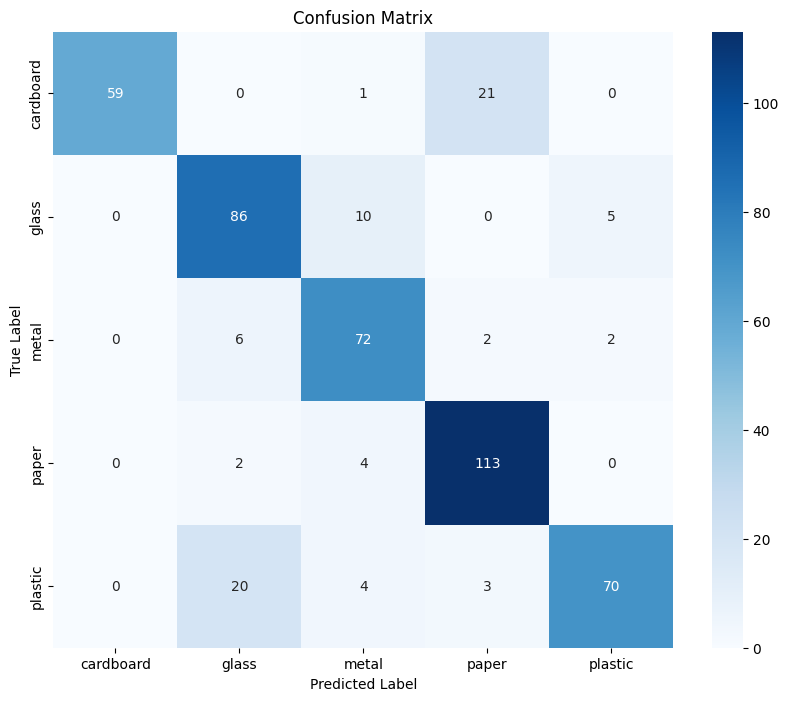


--- Starting process for model: mobilenet_v2 ---

Building model with mobilenet_v2...
Model built successfully with a custom classifier.

Starting training...
Epoch 1/3
----------
train Loss: 1.1553 Acc: 0.5864
validation Loss: 0.8365 Acc: 0.7521
Epoch 2/3
----------
train Loss: 0.7460 Acc: 0.7806
validation Loss: 0.6453 Acc: 0.8271
Epoch 3/3
----------
train Loss: 0.6226 Acc: 0.8110
validation Loss: 0.5786 Acc: 0.8271

Training complete!

Starting model evaluation on the validation set...

Classification Report:
              precision    recall  f1-score   support

   cardboard       0.96      0.85      0.90        81
       glass       0.76      0.78      0.77       101
       metal       0.78      0.88      0.83        82
       paper       0.86      0.90      0.88       119
     plastic       0.80      0.72      0.76        97

    accuracy                           0.83       480
   macro avg       0.83      0.83      0.83       480
weighted avg       0.83      0.83      0.83   

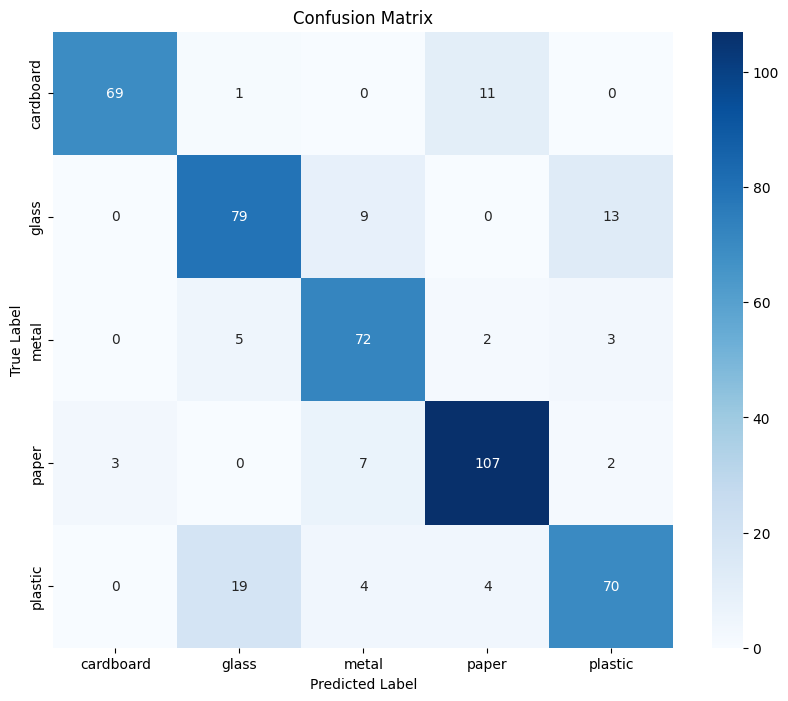


--- Starting process for model: efficientnet_b0 ---

Building model with efficientnet_b0...
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\murug/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:03<00:00, 7.05MB/s]


Model built successfully with a custom classifier.

Starting training...
Epoch 1/3
----------
train Loss: 1.1177 Acc: 0.6267
validation Loss: 0.8036 Acc: 0.7562
Epoch 2/3
----------
train Loss: 0.7327 Acc: 0.7775
validation Loss: 0.6237 Acc: 0.7937
Epoch 3/3
----------
train Loss: 0.6073 Acc: 0.8037
validation Loss: 0.5695 Acc: 0.7958

Training complete!

Starting model evaluation on the validation set...

Classification Report:
              precision    recall  f1-score   support

   cardboard       0.96      0.83      0.89        81
       glass       0.70      0.77      0.73       101
       metal       0.73      0.83      0.78        82
       paper       0.84      0.86      0.85       119
     plastic       0.81      0.69      0.74        97

    accuracy                           0.80       480
   macro avg       0.81      0.80      0.80       480
weighted avg       0.80      0.80      0.80       480


Generating confusion matrix...


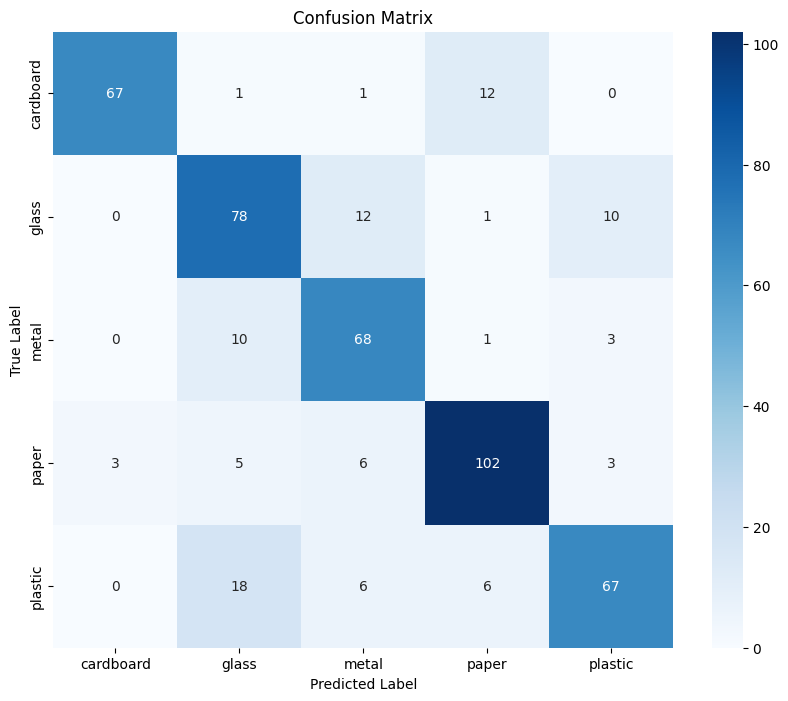


--- Final Model Comparison ---
Model: resnet50        F1-Score: 0.8312
Model: mobilenet_v2    F1-Score: 0.8275
Model: efficientnet_b0 F1-Score: 0.7976

Best Model: resnet50 with an F1-Score of 0.8312


In [ ]:
# --- Script Execution ---
if __name__ == '__main__':
    try:
        # Get data loaders and class names
        dataloaders, dataset_sizes, class_names = get_data_loaders(DATA_ROOT, IMAGE_SIZE, BATCH_SIZE)
        
        # Dynamically set NUM_CLASSES based on the loaded dataset
        NUM_CLASSES = len(class_names)
        
        best_f1_score = -1.0
        best_model_name = ""
        results = {}
        trained_models = {}

        # Loop through each model to build, train, and evaluate
        for model_name in MODELS_TO_TEST:
            print(f"\n--- Starting process for model: {model_name} ---")
            
            model_ft = build_model(model_name, NUM_CLASSES)
            model_ft = train_model(model_ft, dataloaders, dataset_sizes, NUM_EPOCHS, LEARNING_RATE)
            f1_score = evaluate_model(model_ft, dataloaders, class_names)
            
            results[model_name] = f1_score
            
            # Check if this model is the new best
            if f1_score > best_f1_score:
                best_f1_score = f1_score
                best_model_name = model_name
        
        # Print final summary of all model F1-scores
        print("\n--- Final Model Comparison ---")
        for model_name, f1 in results.items():
            print(f"Model: {model_name:<15} F1-Score: {f1:.4f}")
        
        print(f"\nBest Model: {best_model_name} with an F1-Score of {best_f1_score:.4f}")
        
    except Exception as e:
        print(f"An error occurred: {e}")

In [26]:
# --- NEW STEP: Save the best model ---
print(f"Saving the best model to {BEST_MODEL_PATH}...")
best_model_to_save = trained_models[best_model_name]
torch.save(best_model_to_save.state_dict(), BEST_MODEL_PATH)
print("Model saved successfully. You can now run the Streamlit app.")

Saving the best model to best_model.pth...


NameError: name 'trained_models' is not defined